概要：维数灾难是很可怕的，数据集包含成千上万的特征，会让训练过程很慢，同时很难找到很好的解，解决这个问题主要是降维。

1.幸运的是，在现实生活中我们经常可以极大的降低特征维度，将一个十分棘手的问题转变成一个可以较为容易解决的问题。

比如mnist数据集，图片四周边缘部分的像素几乎总是白的，因此你完全可以将这些像素从你的训练集中扔掉而不会丢失太多信息。

同时，两个相邻的像素往往是高度相关的：如果你想要将他们合并成一个像素（比如取这两个像素点的平均值）你并不会丢失很多信息。

* 降维会丢失信息，即使这种方法可以加快训练的速度，同时也会让你的系统表现的稍微差一点。降维会让你的工作流水线更复杂因而更难维护。所有你应该先尝试使用原始的数据来训练，如果训练速度太慢的话再考虑使用降维。

在某些情况下，降低训练集数据的维度可能会筛选掉一些噪音和不必要的细节，这可能会让你的结果比降维之前更好（这种情况通常不会发生；它只会加快你训练的速度）。

2.维数灾难。

在高维超正方体中，大多数点都分布在边界处。高维数据集有很大风险分布的非常稀疏：大多数训练实例可能彼此远离。

训练集的维度越高，过拟合的风险就越大。

3.降维的主要方法。

* 投影（Projection）

在大多数现实生活的问题中，训练实例并不是在所有维度上均匀分布的。许多特征几乎是常
数，而其他特征则高度相关（如前面讨论的 MNIST）。结果，所有训练实例实际上位于（或
接近）高维空间的低维子空间内。

下面的例子：

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
np.allclose(X2D, -X2D_using_svd)

True

In [10]:
X3D_inv = pca.inverse_transform(X2D)

In [11]:
np.allclose(X3D_inv, X)

False

In [12]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [13]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [14]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [15]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [16]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [17]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

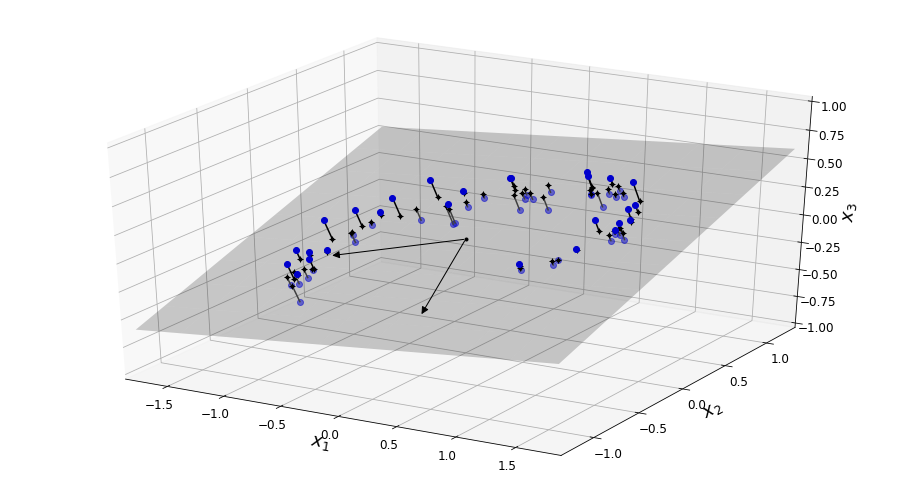

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 8.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

上面的例子中，三维数据集中的点主要分布在二维平面内，用投影的办法将其映射到二维平面里。

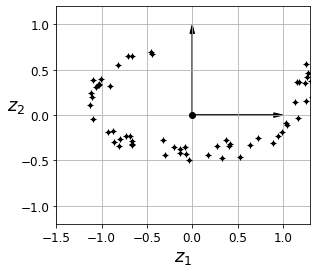

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

上图是一个经过投影的新的2D数据集。z1,z2是新的特征。

* 流形学习。

投影如果用在扭动和卷曲的数据集上，效果并不好，如下例：

In [21]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

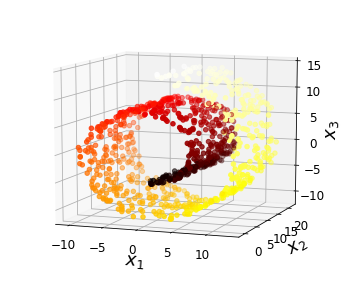

In [22]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

这是瑞士卷的数据集，它是旋转，扭曲的。

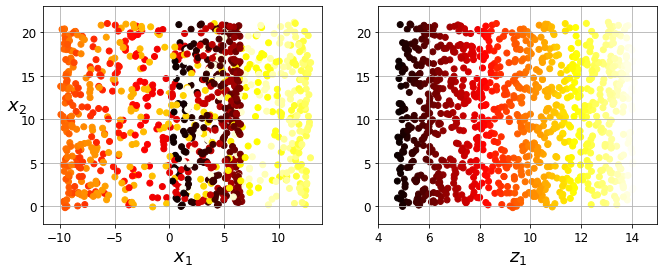

In [23]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

左图直接丢弃了X3特征，数据点都重合了，但我们需要的是右图的效果，它是均匀分布的。

瑞士卷一个是二维流形的例子。简而言之，二维流形是一种二维形状，它可以在更高维空间
中弯曲或扭曲。更一般地，一个 d 维流形是类似于 d 维超平面的 n 维空间（其中 d < n ）
的一部分。在我们瑞士卷这个例子中， d = 2 ， n = 3 ：它有些像 2D 平面，但是它实际上
是在第三维中卷曲。

许多降维算法通过对训练实例所在的流形进行建模从而达到降维目的；这叫做流形学习。

许多降维算法通过对训练实例所在的流形进行建模从而达到降维目的；这叫做流形学习。它
依赖于流形猜想（manifold assumption），也被称为流形假设（manifold hypothesis），它
认为大多数现实世界的高维数据集大都靠近一个更低维的流形。这种假设经常在实践中被证
实。

让我们再回到 MNIST 数据集：所有手写数字图像都有一些相似之处。它们由连线组成，边界
是白色的，大多是在图片中中间的，等等。如果你随机生成图像，只有一小部分看起来像手
写数字。换句话说，如果您尝试创建数字图像，那么您的自由度远低于您生成任何随便一个
图像时的自由度。这些约束往往会将数据集压缩到较低维流形中。

看下面的例子：

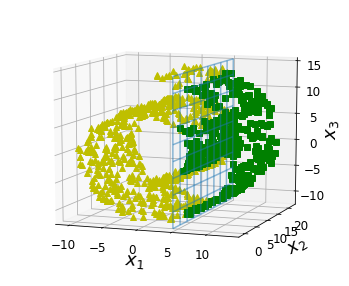

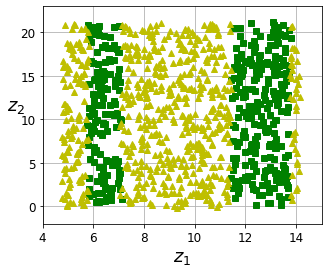

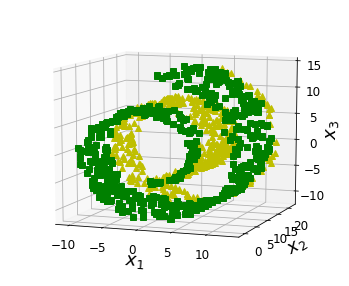

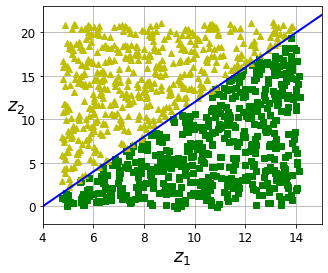

In [25]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

流形假设通常包含着另一个隐含的假设：你现在的手上的工作（例如分类或回归）如果在流
形的较低维空间中表示，那么它们会变得更简单。例如，在图3中，瑞士卷被分
为两类：在三维空间中，分类边界会相当复杂，但在二维展开的流形空间中（图
4），分类边界是一条简单的直线。

但是，这个假设并不总是成立。例如，在图 1，决策边界位于 x1 = 5 。这个决策边界在原始三维空间（一个垂直平面）看起来非常简单，但在展开的流形中
却变得更复杂了（四个独立线段的集合）（图2）。

简而言之，如果在训练模型之前降低训练集的维数，那训练速度肯定会加快，但并不总是会
得出更好的训练效果；这一切都取决于数据集。

* 决策边界并不总是会在低维空间中变的简单

3.主成分分析。

主成分分析（Principal Component Analysis）是目前为止最流行的降维算法。首先它找到接
近数据集分布的超平面，然后将所有的数据都投影到这个超平面上。